** Imports**

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import math

In [24]:
from costs import *
from models import *
from helpers import * 
from evaluation import *
from split_data import *
from split_features import *

## Data loading
** Load the training data into feature matrix, class labels, and record ids**

We write our own `load_csv_data` function to import csv data, which gives us prediction column, feature matrix and each record ID.

In [3]:
from proj1_helpers import *
DATA_TRAIN_PATH = 'data/train.csv' # TODO: download train data and supply path here 
y, tx, ids = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)

### Split the dataset into trainset and testset in order to test accuracy

In [4]:
x_train, y_train, x_test, y_test = split_data(tx, y, 0.9)

In [5]:
x_train.shape

(225000, 30)

In [6]:
tx = x_train
y = y_train

## Data Preprocessing

### Split into 6 distinct datasets

According to our exploration, we can distinct 3 different dataset based on number of jets each experiments contains. Then each of them can be split again into 2 different datasets based on whether they have a measurable mass or not.

In [7]:
jet0, jet1, jet23, y0, y1, y23 = split_on_jets(y, tx)
jet0_nomass, jet0, y0_nomass, y0 = split_on_mass(y0, jet0)
jet1_nomass, jet1, y1_nomass, y1 = split_on_mass(y1, jet1)
jet23_nomass, jet23, y23_nomass, y23 = split_on_mass(y23, jet23)

### Only keep the features without NaN in each subset

In [8]:
jet0_nomass, selected_jet0_nomass = select_features_without_nan(jet0_nomass)
jet0, selected_jet0 = select_features_without_nan(jet0)
jet1_nomass, selected_jet1_nomass = select_features_without_nan(jet1_nomass)
jet1, selected_jet1 = select_features_without_nan(jet1)
jet23_nomass, selected_jet23_nomass = select_features_without_nan(jet23_nomass)
jet23, selected_jet23 = select_features_without_nan(jet23)


### TODO: remove more features ! some are flat, some are even unique !!

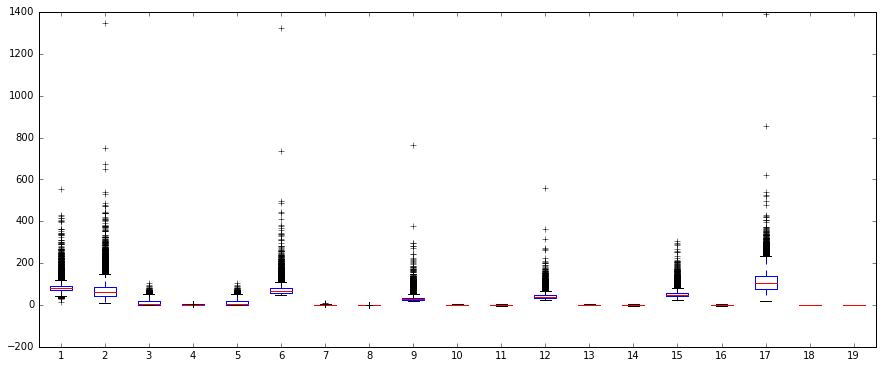

In [39]:
boxplot_five_number(jet0_nomass)

### Standardization of values
We use [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) method to standardize our feature matrix, i.e. to rescale tx down to [0, 1], so as to avoid complicated computation caused by large numbers.

In [9]:
tx = standardize(tx)
std_jet0_nomass, min0_nomass, range0_nomass = standardize(jet0_nomass)
std_jet0, min0, range0 = standardize(jet0)
std_jet1_nomass, min1_nomass, range1_nomass = standardize(jet1_nomass)
std_jet1, min1, range1 = standardize(jet1)
std_jet23_nomass, min23_nomass, range23_nomass = standardize(jet23_nomass)
std_jet23, min23, range23 = standardize(jet23)

## Machine Learning

### Logistic Regression

Choose intial parameters

In [15]:
n_iters = 10000
gamma = 0.000003

Train with logistic regression

In [16]:
print("w0_nomass")
loss0_nomass, w0_nomass = logistic_regression(y0_nomass, std_jet0_nomass, gamma, n_iters)
print("w0")
loss0, w0 = logistic_regression(y0, std_jet0, gamma, n_iters)

print("w1_nomass")
loss1_nomass, w1_nomass = logistic_regression(y1_nomass, std_jet1_nomass, gamma, n_iters)
print("w1")
loss1_nomass, w1 = logistic_regression(y1, std_jet1, gamma, n_iters)

print("w23_nomass")
loss23_nomass, w23_nomass = logistic_regression(y23_nomass, std_jet23_nomass, gamma, n_iters)
print("w23")
loss23, w23 = logistic_regression(y23, std_jet23, gamma, n_iters)


w0_nomass
Current iteration=0, the loss=16320.150366283911, gradient=0.07172256268592511
Current iteration=500, the loss=16321.472419235455, gradient=0.07156450444979548
Current iteration=1000, the loss=16322.79163101393, gradient=0.0714068007823273
Current iteration=1500, the loss=16324.10800749434, gradient=0.07124945090170577
Current iteration=2000, the loss=16325.421554540579, gradient=0.07109245402786779
Current iteration=2500, the loss=16326.732278005476, gradient=0.07093580938249835
Current iteration=3000, the loss=16328.040183730782, gradient=0.07077951618902632
Current iteration=3500, the loss=16329.345277547192, gradient=0.0706235736726209
Current iteration=4000, the loss=16330.647565274374, gradient=0.07046798106018756
Current iteration=4500, the loss=16331.94705272098, gradient=0.07031273758036433
Current iteration=5000, the loss=16333.243745684658, gradient=0.07015784246351797
Current iteration=5500, the loss=16334.537649952066, gradient=0.07000329494173996
Current iterati

## Accuracy testing against virtual test_set

In [35]:
testset = x_test

y_pred = apply_right_model(testset, \
                  selected_jet0_nomass, selected_jet0, selected_jet1_nomass, selected_jet1, \
                  selected_jet23_nomass, selected_jet23, \
                  min0_nomass, min0, min1_nomass, min1, min23_nomass, min23, \
                  range0_nomass, range0, range1_nomass, range1, range23_nomass, range23, \
                  w0_nomass, w0, w1_nomass, w1, w23_nomass, w23)


In [36]:
test_accuracy(y_test, y_pred)

0.79532

## Output prediction to Kaggle

In [ ]:
test_x = np.genfromtxt('data/test.csv', delimiter=',', skip_header=1)

In [ ]:
ids = test_x[:, 0]
testset = test_x[:, 2:] # remove id and prediction columns

y = []

for x_t in testset:
    x = np.array([x_t])
    if isJet0_nomass(x):
        pred = x[:,selected_jet0_nomass]
        pred, _ , _ = standardize(pred, min0_nomass, range0_nomass)
        y.append(log_reg_predict(pred, w0_nomass))
    elif isJet0(x):
        pred = x[:, selected_jet0]
        pred, _ , _  = standardize(pred, min0, range0)
        y.append(log_reg_predict(pred, w0))
    elif isJet1_nomass(x):
        pred = x[:, selected_jet1_nomass]
        pred, _ , _  = standardize(pred,min1_nomass, range1_nomass)
        y.append(log_reg_predict(pred, w1_nomass))
    elif isJet1(x):
        pred = x[:, selected_jet1]
        pred, _ , _  = standardize(pred, min1, range1)
        y.append(log_reg_predict(pred, w1))
    elif isJet23_nomass(x):
        pred= x[:, selected_jet23_nomass]
        pred, _ , _  = standardize(pred, min23_nomass, range23_nomass)
        y.append(log_reg_predict(pred, w23_nomass))
    else:
        pred= x[:, selected_jet23]
        pred, _ , _  = standardize(pred, min23, range23)
        y.append(log_reg_predict(pred, w23))


In [ ]:
create_csv_submission(ids, y, 'data/split_data.csv')

In [ ]:
ids = test_x[:, 0]
testset = test_x[:, 2:] # remove id and prediction columns

jet0_nm_ids = np.where((testset[:,22] == 0) & (testset[:,0] == -999.))[0]
jet0_ids = np.where((testset[:,22] == 0) & (testset[:,0] != -999.))[0]
jet1_nm_ids = np.where((testset[:,22] == 1) & (testset[:,0] == -999.))[0]
jet1_ids = np.where((testset[:,22] == 1) & (testset[:,0] != -999.))[0]
jet23_nm_ids = np.where(((testset[:,22] == 2) | (testset[:,22] == 3)) \
                        & (testset[:,0] == -999.))[0]
jet23_ids = np.where(((testset[:,22] == 2) | (testset[:,22] == 3)) \
                        & (testset[:,0] != -999.))[0]

jet0_test_nm = testset[jet0_nm_ids][:, selected_jet0_nomass]
jet0_test = testset[jet0_ids][:, selected_jet0]
jet1_test_nm = testset[jet1_nm_ids][:, selected_jet1_nomass]
jet1_test = testset[jet1_ids][:, selected_jet1]
jet23_test_nm = testset[jet23_nm_ids][:, selected_jet23_nomass]
jet23_test = testset[jet23_ids][:, selected_jet23]

higgs_jet0_nm = np.where(log_reg_predict(jet0_test_nm, w0_nomass) == 1)[0]
higgs_jet0 = np.where(log_reg_predict(jet0_test, w0) == 1)[0]
higgs_jet1_nm = np.where(log_reg_predict(jet1_test_nm, w1_nomass) == 1)[0]
higgs_jet1 = np.where(log_reg_predict(jet1_test, w1) == 1)[0]
higgs_jet23_nm = np.where(log_reg_predict(jet23_test_nm, w23_nomass) == 1)[0]
higgs_jet23 = np.where(log_reg_predict(jet23_test, w23) == 1)[0]


### retrieve the id's of higgs boson

In [ ]:
import itertools

higgs = itertools.chain(ids[jet0_nm_ids][higgs_jet0_nm], ids[jet0_ids][higgs_jet0] \
               , ids[jet1_nm_ids][higgs_jet1_nm], ids[jet1_ids][higgs_jet1]\
               , ids[jet23_nm_ids][higgs_jet23_nm], ids[jet23_ids][higgs_jet23])

higgs_arr = list([int(i) for i in higgs])

In [ ]:
res = []
for i in range(350000,918238):
    if i in higgs_arr:
        res.append([i, 1])
    else:
        res.append([i, -1])
        
res

In [ ]:
prediction = apply_right_model(testset, ids, w0_nomass, w0, w1_nomass, ...
                               w1, w23_nomass, w23, selected_jet0_nomass, ...
                              selected_jet0, selected_jet1_nomass, selected_jet1, ...
                              selected_jet23_nomass, selected_jet23)
prediction

In [ ]:
print("higgs: ", np.count_nonzero(prediction == 1))
print("non-higgs: ", np.count_nonzero(prediction == -1))

In [ ]:
test_x = np.genfromtxt('data/test.csv', delimiter=',', skip_header=1)
test_x = standardize(test_x[:, 2:])  # remove id and prediction columns
# could've used load_csv_data
create_csv_submission([i for i in range(350000,918238)], log_reg_predict(test_x, w), 'res.csv')

In [ ]:
test_jet0

## Feature Engineering
TODO

## Prediction

**Generate predictions and save ouput in csv format for submission**